In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from game.Bankgames import *
from game.plotting import *
from game.distributions import TruncatedGaussian, Uniform, PiecewiseUniform
import nashpy as nh
from tqdm import tqdm
from utils.project_dirs import *
from game.run_game import *
import os

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 17,                   # Set font size to 11pt
    'axes.labelsize': 20,               # -> axis labels
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'legend.fontsize': 18,
    'lines.linewidth':2,
    'text.usetex': False,
    'pgf.rcfonts': False,
})

In [3]:
def plotsave_game_probability(game_result, save_dir, figsize=(12, 5), file_prefix=''):
    """
    Plots the probability evolution of actions for Bank 1 and Bank 2 and saves them as separate figures.

    Parameters:
    - game_result (tuple): A single tuple containing (p_b1, p_b2, gammas, taus).
      - p_b1 has shape (#rounds, #actions)
      - p_b2 has shape (#rounds, #actions)
      - gammas and taus define the action pairs
    - save_dir (str): Directory where the plots will be saved.
    - figsize (tuple): Size of the figure.
    """
    # Unpack the game result
    p_b1, p_b2, gammas, taus = game_result
    n = len(gammas)
    assert len(taus) == n, "Number of gammas and taus must be equal"

    T, num_actions = p_b1.shape  # Number of time steps and actions
    assert num_actions == n * n, "Mismatch between number of actions and (tau, gamma) pairs"

    time_steps = np.arange(T)  # Time steps
    color_map = plt.cm.hsv
    colors = [color_map(i / num_actions) for i in range(num_actions)]  # Assign distinct colors

    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Function to plot and save for a given bank
    def plot_and_save(probabilities, title, filename):
        plt.figure(figsize=figsize)
        for action in range(num_actions):
            tau_idx = action // n
            gamma_idx = action % n
            tau = taus[tau_idx]
            gamma = gammas[gamma_idx]

            plt.plot(time_steps, probabilities[:, action], 
                     color=colors[action], 
                     label=f'(τ={tau:.2f}, γ={gamma:.2f})',
                     linewidth=2)
            
        plt.title(f'{title} weights, {file_prefix}')
        plt.xlabel('Round')
        plt.ylabel('Probability')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Save the figure
        save_path = os.path.join(save_dir, filename)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()

    # Generate and save plots for Bank 1 and Bank 2 separately
    plot_and_save(p_b1, "Bank 1", f"{file_prefix}Bank1.pdf")
    plot_and_save(p_b2, "Bank 2", f"{file_prefix}Bank2.pdf")

In [3]:
def plot_mean_sem_over_time(dist_data, labels, title_prefix="Distance to Closest NE"):
    """
    Plots the mean and standard error of the mean (SEM) over time for multiple distance metrics.

    Parameters:
    - dist_data: dict {label -> pd.Series} where each series contains numpy arrays of shape (num_experiments, num_rounds)
    - labels: list of str, names for each metric (used in titles and legends)
    - title_prefix: str, prefix for the plot titles
    """
    num_metrics = len(dist_data)
    
    # Create subplots: one per metric
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 5 * num_metrics), sharex=True)

    if num_metrics == 1:
        axes = [axes]  # Ensure it's iterable if only one plot

    for ax, (label, series) in zip(axes, dist_data.items()):
        # Convert to numpy array (shape: num_experiments x num_rounds)
        data = np.array(series.tolist())  
        num_experiments = data.shape[0]

        # Compute mean and standard error of the mean (SEM)
        mean_dist = np.mean(data, axis=0)
        sem_dist = np.std(data, axis=0) / np.sqrt(num_experiments)

        # Time steps
        rounds = np.arange(len(mean_dist))

        # Plot mean with shaded SEM region
        ax.plot(rounds, mean_dist, label=f"{label} - Mean", linewidth=2)
        ax.fill_between(rounds, mean_dist - sem_dist, mean_dist + sem_dist, alpha=0.2, label=f"{label} ± 1 SEM")

        # Labels and title
        ax.set_ylabel("L2 Distance")
        ax.set_title(f"{title_prefix} ({label})")
        ax.legend()
        ax.grid(alpha=0.3)

    axes[-1].set_xlabel("Rounds")  # Only the last subplot gets the x-label
    plt.suptitle(title_prefix, fontsize=14)
    plt.tight_layout()
    plt.show()

In [4]:
def get_significant(ne_profiles, tolerance=1e-6, decimal_places=3):
    """
    Formats numbers in a list of tuples of numpy arrays to a given number of decimal places,
    while masking values smaller than the specified tolerance.

    Parameters:
        ne_profiles (list of tuples of np.ndarray): List of Nash equilibrium profiles.
        tolerance (float): Threshold below which values are replaced with 0.
        decimal_places (int): Number of decimal places to round values.

    Returns:
        list of tuples of np.ndarray: Processed list with small values masked and rounded.
    """
    def process_array(arr):
        masked_arr = np.where(np.abs(arr) < tolerance, 0, arr)  # Mask small values
        return np.round(masked_arr, decimals=decimal_places)  # Round to desired decimal places

    formatted_profiles = [
        tuple(process_array(arr) for arr in profile)
        for profile in ne_profiles
    ]
    
    return formatted_profiles

# Fig A2 in appendix
## mu 0.1 sigma 0.3
## gammas - 0.1, 0.4, 0.8

In [19]:
gammas = sorted([0.1, 0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])

mu = 0.1
sigma = 0.3

tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix(gammas=gammas, taus=taus, dist=tg)

In [20]:
get_significant(gtm.NE_ve)  # these are what we get from running vertex enumeration on the utility matrix i.e. one-shot game's NE

[(array([0., 0., 0., 0., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0.])),
 (array([0.   , 0.   , 0.057, 0.   , 0.   , 0.   , 0.943, 0.   , 0.   ]),
  array([0.   , 0.   , 0.057, 0.   , 0.   , 0.   , 0.943, 0.   , 0.   ])),
 (array([0.   , 0.   , 0.319, 0.   , 0.16 , 0.   , 0.521, 0.   , 0.   ]),
  array([0.   , 0.   , 0.319, 0.   , 0.16 , 0.   , 0.521, 0.   , 0.   ]))]

In [26]:
# uniform init
# p_a = np.ones(9)/9
# p_b = np.ones(9)/9

# init at mixed NE1
# p_a, p_b = gtm.NE_ve[1]
# print(p_a, p_b)

# init at mixed NE2
p_a, p_b = gtm.NE_ve[2]
print(p_a, p_b)

[-9.09881980e-18  2.72964594e-17  3.18997217e-01 -9.09881980e-18
  1.59677292e-01 -1.81976396e-17  5.21325491e-01 -1.81976396e-17
 -2.72964594e-17] [-9.09881980e-18  2.72964594e-17  3.18997217e-01 -9.09881980e-18
  1.59677292e-01 -1.81976396e-17  5.21325491e-01 -1.81976396e-17
 -2.72964594e-17]


In [27]:
eta = 0.1
T = 50000
save_dir = '../plots/3gamma-dynamics/'

# run hedge on known matrix
b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1])
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Known-Matrix')

gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=tg, num_samples=1)
b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1])
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Fresh-Estimate')

gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)
b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1]) 
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Moving-Estimate')

[-1.24925769e-59  4.97617876e-30  3.18997217e-01 -7.16003426e-27
  1.59677292e-01 -3.40892035e-29  5.21325491e-01 -2.44835820e-26
 -1.34582860e-52] [-1.24925769e-59  4.97617876e-30  3.18997217e-01 -7.16003426e-27
  1.59677292e-01 -3.40892035e-29  5.21325491e-01 -2.44835820e-26
 -1.34582860e-52]
[-3.10564690e-59  1.25994904e-59  6.83045194e-09 -2.31171942e-26
  5.52711462e-31 -2.57220357e-38  9.99999993e-01 -4.24287324e-56
 -1.46516372e-67] [-3.10564690e-59  1.25994904e-59  6.83045194e-09 -2.31171942e-26
  5.52711462e-31 -2.57220357e-38  9.99999993e-01 -4.24287324e-56
 -1.46516372e-67]
[-2.02172386e-58  7.29781531e-54  3.58575164e-11 -8.48033388e-27
  8.13836010e-26 -3.19221709e-40  1.00000000e+00 -5.24570207e-51
 -2.85595868e-68] [-2.02172386e-58  7.29781531e-54  3.58575164e-11 -8.48033388e-27
  8.13836010e-26 -3.19221709e-40  1.00000000e+00 -5.24570207e-51
 -2.85595868e-68]


In [12]:
eta = 0.1
T = 50000
b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
# print(b1[-1], b2[-1])

# gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)
b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
# print(b1[-1], b2[-1]) 

np.allclose(gma.A_est, gtm.A, atol = 1/(T)**0.5) # estimated and true are within 1/sqrt(T) for every element

True

In [10]:
T = 1000
b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
# print(b1[-1], b2[-1])

gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)
b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
# print(b1[-1], b2[-1]) 

np.allclose(gma.A_est, gtm.A, atol = 1/(T)**0.5)

True

# Fig A1 in appendix
## mu 0.3 sigma 0.1
## gammas - 0.1, 0.4, 0.8

In [58]:
mu = 0.3
sigma = 0.1

In [59]:
gammas = sorted([0.1, 0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])

tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix(gammas=gammas, taus=taus, dist=tg)

In [60]:
get_significant(gtm.NE_ve)  # these are what we get from running vertex enumeration on the utility matrix i.e. one-shot game's NE

[(array([0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0.]))]

In [40]:
# uniform init
p_a = np.ones(9)/9
p_b = np.ones(9)/9

# init at mixed NE1
# p_a, p_b = gtm.NE_ve[1]
# print(p_a, p_b)

# # init at mixed NE2
# p_a, p_b = gtm.NE_ve[2]
# print(p_a, p_b)

In [41]:
eta = 0.1
T = 50000
save_dir = '../plots/3gamma-dynamics/'

# run hedge on known matrix
b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1])
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Known-Matrix')

gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=tg, num_samples=1)
b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1])
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Fresh-Estimate')

gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)
b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1]) 
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Moving-Estimate')

[3.87831627e-128 9.88608630e-051 1.00000000e+000 3.63680716e-060
 1.90632924e-023 1.70348848e-014 2.33251288e-047 2.14743763e-034
 7.12016641e-036] [3.87831627e-128 9.88608630e-051 1.00000000e+000 3.63680716e-060
 1.90632924e-023 1.70348848e-014 2.33251288e-047 2.14743763e-034
 7.12016641e-036]
[2.82379349e-128 5.49118866e-051 1.00000000e+000 8.44122822e-060
 2.34439716e-023 1.94940101e-014 4.93803127e-047 4.34510090e-034
 1.54423899e-035] [2.82379349e-128 5.49118866e-051 1.00000000e+000 8.44122822e-060
 2.34439716e-023 1.94940101e-014 4.93803127e-047 4.34510090e-034
 1.54423899e-035]
[1.69268883e-127 2.20691680e-050 1.00000000e+000 1.38936279e-060
 1.00005669e-023 1.64567573e-014 1.24458438e-047 3.99699931e-035
 1.64852693e-036] [1.69268883e-127 2.20691680e-050 1.00000000e+000 1.38936279e-060
 1.00005669e-023 1.64567573e-014 1.24458438e-047 3.99699931e-035
 1.64852693e-036]


# Fig A3 in appendix
## mu = 0.1
## sigma = 0.2

In [61]:
mu = 0.1
sigma = 0.2

gammas = sorted([0.1, 0.4, 0.8])
taus = sorted([1/(2+gamma) for gamma in gammas])

tg = TruncatedGaussian(mu = mu, sigma = sigma)
gtm = GameTrueMatrix(gammas=gammas, taus=taus, dist=tg)

In [62]:
get_significant(gtm.NE_ve)  # these are what we get from running vertex enumeration on the utility matrix i.e. one-shot game's NE

[(array([0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 1., 0., 0., 0., 0., 0., 0.])),
 (array([0.   , 0.   , 0.619, 0.   , 0.381, 0.   , 0.   , 0.   , 0.   ]),
  array([0.   , 0.   , 0.619, 0.   , 0.381, 0.   , 0.   , 0.   , 0.   ])),
 (array([0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0.]))]

In [71]:
# uniform init
# p_a = np.ones(9)/9
# p_b = np.ones(9)/9

# init at mixed NE1
# p_a, p_b = gtm.NE_ve[1]
# print(p_a, p_b)

# # init near pure NE2
# p_a, p_b = gtm.NE_ve[2]
# print(p_a, p_b)
# p_a, p_b = np.array([0., 0., 0., 0., 0.8, 0.2, 0., 0., 0.]), np.array([0., 0., 0., 0., 0.8, 0.2, 0., 0., 0.])

In [72]:
eta = 0.1
T = 50000
save_dir = '../plots/3gamma-dynamics/'

# run hedge on known matrix
b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1])
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Known-Matrix')

gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=tg, num_samples=1)
b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1])
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Fresh-Estimate')

gma = GameMovingAvg(gammas=gammas, taus=taus, dist=tg, num_samples=1)
b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1]) 
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Moving-Estimate')

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.97088925e-19 0.00000000e+00 0.00000000e+00
 0.00000000e+00] [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 1.97088925e-19 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 2.10061403e-19 0.00000000e+00 0.00000000e+00
 0.00000000e+00] [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 2.10061403e-19 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 4.90958426e-19 0.00000000e+00 0.00000000e+00
 0.00000000e+00] [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.00000000e+00 4.90958426e-19 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


# Fig A4 appendix

piecewise uniform

In [85]:
# piecewise uniform
gamma_l, gamma_h = 0.6, 0.7
puf = PiecewiseUniform(ga_l = gamma_l, ga_h = gamma_h) #needs exactly these gamma_l and high values
gammas = [0.1, 0.6, 0.7]
taus = sorted([1/(2+gamma) for gamma in gammas])

gtm = GameTrueMatrix(gammas=gammas, taus=taus, dist=puf)

In [86]:
get_significant(gtm.NE_ve) # all 3 are mixed NE, 2 is asymmetric mixed NE, 1 is symmetric mixed NE

[(array([0.   , 0.   , 0.055, 0.   , 0.945, 0.   , 0.   , 0.   , 0.   ]),
  array([0.   , 0.   , 0.772, 0.   , 0.   , 0.   , 0.228, 0.   , 0.   ])),
 (array([0.   , 0.   , 0.772, 0.   , 0.   , 0.   , 0.228, 0.   , 0.   ]),
  array([0.   , 0.   , 0.055, 0.   , 0.945, 0.   , 0.   , 0.   , 0.   ])),
 (array([0.   , 0.   , 0.293, 0.   , 0.707, 0.   , 0.   , 0.   , 0.   ]),
  array([0.   , 0.   , 0.293, 0.   , 0.707, 0.   , 0.   , 0.   , 0.   ]))]

In [87]:
# uniform init
# p_a = np.ones(9)/9
# p_b = np.ones(9)/9

# init at asymmetric mixed NE
p_a, p_b = gtm.NE_ve[0]
print(p_a, p_b)

[-1.14817683e-17 -1.14817683e-17  5.53890555e-02 -1.14817683e-17
  9.44610944e-01 -1.14817683e-17 -1.14817683e-17 -1.14817683e-17
 -1.14817683e-17] [ 1.18220396e-17  1.18220396e-17  7.71693519e-01 -1.18220396e-17
 -1.18220396e-17 -1.18220396e-17  2.28306481e-01 -1.18220396e-17
 -1.18220396e-17]


In [90]:
eta = 0.1
T = 200000
save_dir = '../plots/3gamma-dynamics/'

# run hedge on known matrix
b1,b2,gammas,taus = gtm.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1])
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Known-Matrix')

gfe = GameFreshEstimate(gammas=gammas, taus=taus, dist=puf, num_samples=1)
b1,b2,gammas,taus = gfe.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1])
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Fresh-Estimate')

gma = GameMovingAvg(gammas=gammas, taus=taus, dist=puf, num_samples=1)
b1,b2,gammas,taus = gma.run_hedge(T=T, p_b1=p_a, p_b2=p_b, eta=eta)
print(b1[-1], b2[-1]) 
plotsave_game_probability((b1,b2,gammas,taus), save_dir, figsize=(12, 5), file_prefix='Moving-Estimate')

[-1.33397724e-322 -1.78933062e-170  5.53890555e-002 -1.89943335e-094
  9.44610944e-001 -4.01231932e-115 -1.77804880e-089 -8.03603149e-024
 -2.86189343e-120] [ 1.38338381e-322  1.92148346e-186  7.71693519e-001 -1.26291113e-022
 -1.23297531e-033 -6.06545097e-172  2.28306481e-001 -6.96645600e-037
 -3.55448541e-172]
[-1.48219694e-323 -3.70235733e-171  4.41115812e-001 -3.64351882e-094
  5.58884188e-001 -3.24599536e-114 -4.28705623e-089 -3.78018177e-024
 -1.85546854e-119] [ 1.08694442e-322  2.36087896e-190  4.21489586e-001 -2.54593429e-022
 -4.33184607e-037 -2.78775319e-174  5.78510414e-001 -2.62885286e-040
 -2.11320808e-174]
[-1.33397724e-322 -4.44310464e-171  1.05064363e-002 -1.40501987e-095
  9.89493564e-001 -3.36214399e-115 -2.86204615e-090 -2.02432256e-024
 -7.76740259e-121] [ 1.38338381e-322  6.00155108e-185  9.12900264e-001 -2.21409802e-023
 -1.62459736e-031 -7.85927755e-170  8.70997360e-002 -3.87708005e-035
 -3.76878941e-170]


In [40]:
T = 20000
eta = 0.1
df, df_conc = run_across_init_largegamma(gtm=gtm, save_dir=save_dir, T=T, eta=eta)

100%|█████████████████████████████████████████████| 5/5 [02:46<00:00, 33.36s/it]


In [47]:
df_conc.columns

Index(['instance_name', 'dist', 'gammas', 'taus', 'Bank1_start', 'Bank2_start',
       'hedgeT', 'closestNE_knownmat', 'closestNEdist_knownmat',
       'closestNE_fresh1', 'closestNEdist_fresh1', 'closestNE_moving1',
       'closestNEdist_moving1'],
      dtype='object')

In [50]:
df_conc[['Bank1_start', 'Bank2_start','closestNE_knownmat']]

,Bank1_start,Bank2_start,closestNE_knownmat
0,"[0.021616249915949792, 0.0271086308931775, 0.0...","[0.06957095461260054, 0.06366956463914719, 0.0...","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -5.9..."
1,"[0.27066977267313375, 0.11358025941699568, 0.0...","[0.16783576522150734, 0.1161072798091265, 0.01...","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -5.9..."
2,"[0.21740086975972195, 0.05012093482235036, 0.2...","[0.38681643413428557, 0.02353774443853318, 0.0...","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -5.9..."
3,"[0.13966465542401996, 0.16625050936483554, 0.0...","[0.23121231494033567, 0.012900181782437792, 0....","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -5.9..."
4,"[0.16797507343295692, 0.011271399692211692, 0....","[0.04120749026614079, 0.15355599226261585, 0.1...","([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -5.9..."


In [51]:
df_conc['closestNE_knownmat'][0] # goes to tau_high, gamma_low

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -5.98787651e-18]),
 array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -5.98787651e-18]))

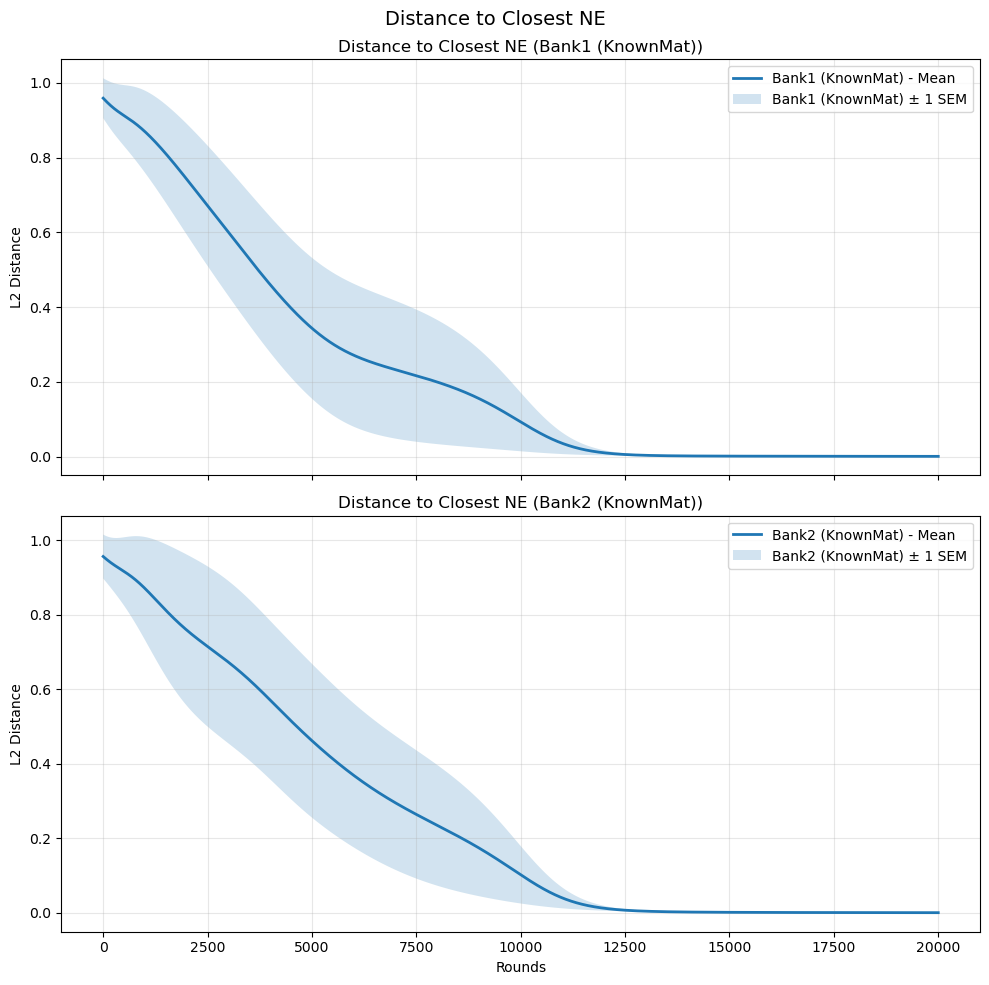

In [42]:
# Example Usage:
plot_mean_sem_over_time(
    {
        "Bank1 (KnownMat)": df['closestNEdist_knownmat_b1'],
        "Bank2 (KnownMat)": df['closestNEdist_knownmat_b2']
    },
    labels=["Bank1", "Bank2"]
)

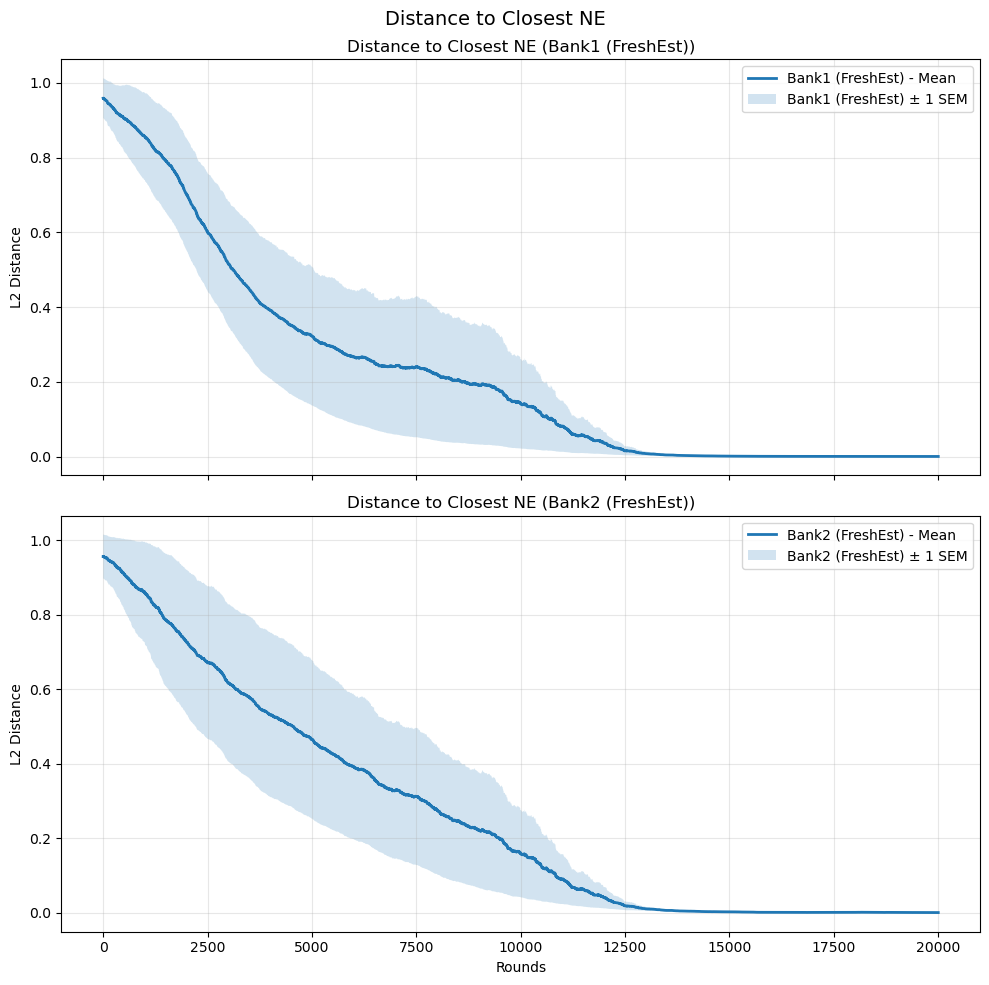

In [43]:
# Example Usage:
plot_mean_sem_over_time(
    {
        "Bank1 (FreshEst)": df['closestNEdist_fresh1_b1'],
        "Bank2 (FreshEst)": df['closestNEdist_fresh1_b2']
    },
    labels=["Bank1", "Bank2"]
)

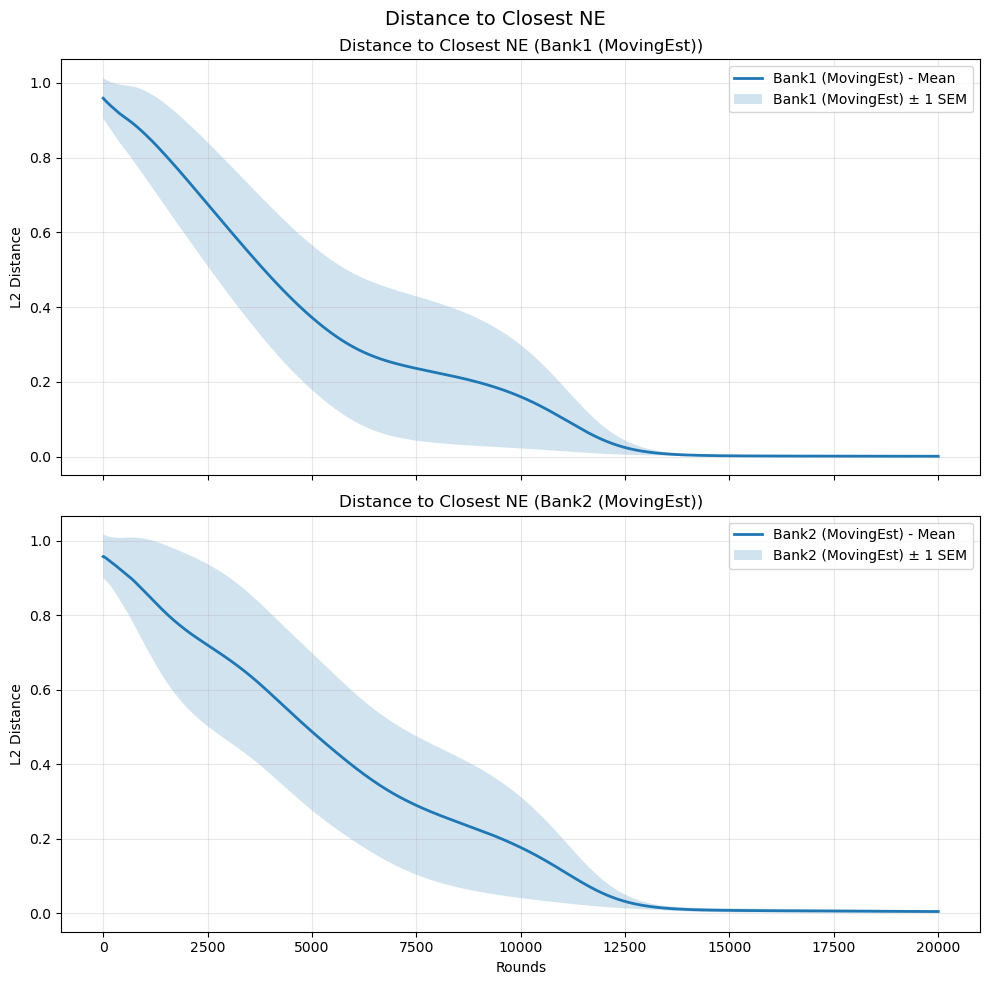

In [44]:
# Example Usage:
plot_mean_sem_over_time(
    {
        "Bank1 (MovingEst)": df['closestNEdist_moving1_b1'],
        "Bank2 (MovingEst)": df['closestNEdist_moving1_b2']
    },
    labels=["Bank1", "Bank2"]
)